In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/UOC/TFM/KETI/

/content/drive/My Drive/UOC/TFM/KETI


In [ ]:
from pandas.core.api import DataFrame
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
pd.set_option("display.precision", 10)
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
from pylab import *
import pickle
import seaborn as sns


In [ ]:
## CONSTANT, PARAMETERS & CONVERT UTILITIES

LIM_MIN = 1377320400
LIM_MAX = 1377925200

## ROOMS
top = '/content/drive/MyDrive/UOC/TFM/KETI'
rooms = []
for root, dirs, files in os.walk(top, topdown=True):
   #print (root)
   #for name in files:
   #   print(os.path.join(root, name))
   for name in dirs:
      rooms.append(name)
rooms.sort(reverse=False)

# DICS TO CONVERT ROOM NUMBER TO SECUENCTIAL AND VICEVERSA
sec = range(0,51)
dic_SecRoom = dict(zip(sec,rooms))
dic_RoomSec = dict(zip(rooms,sec))

# DICS TO CONVERT CATEGORIES TO NUMBER AND VICEVERSA
cats= ['co2', 'Humidity', 'Light', 'Pir', 'Temperature'] 
sec2= range(1,6)

dic_SecCat = dict(zip(sec2,cats))
dic_CatSec = dict(zip(cats,sec2))

# TOTAL RANGE BETWEEN LIMS
totalRange = []

for tR in range(LIM_MIN, LIM_MAX, 5):
 totalRange.append(tR)

cats= ['co2', 'Humidity', 'Light', 'Pir', 'Temperature'] 
feat = ['size','min','max']
ScCats = ["ScCo2", "ScHum","ScLight", "ScPir", "ScTem"]

n_steps = 8
n_features = 1

In [ ]:
print (dic_SecRoom[11])

452


In [ ]:
# FUNCTION TO GENERATE A RANGE FROM A TIME
def timeRange(time):
  m=0
  if time%5 == 0:
    ra = time
  else:
    for h in range(1,5):
      preRa = time - h
      if preRa%5 == 0:
        ra = preRa
        break
  return ra

# FUNCTION TO PLOT ALL ROOMS FROM A CATEGORY
def print_cat(catStr): 
  nrows = 10
  ncols=5 
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,20), constrained_layout=True)
  t = 0
  i = 0
  r = 0
  cat = dic_CatSec [catStr]
  for i in range(0, nrows):
    for t in range(0,ncols):

      ax[i,t].plot(KETI[r][cat][1].iloc[:, 0])
      ax[i,t].title.set_text('Hab. ' + str(r))
      r = r+1

  plt.show()

# FUNCTION TO PLOT A ROOM AND A CATEGORY
def plot_1_room(r, catStr):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,4), constrained_layout=True)
  cat = dic_CatSec [catStr]
  ax.plot(KETI[r][cat][1].iloc[:, 0])
  ax.title.set_text('Hab. ' + dic_SecRoom[r])
  
  plt.show()

# FUNCTION TO CONVERT UNIX TIME TO TIMESTAMP
def unix2time(ut):
  return datetime.datetime.fromtimestamp(ut).strftime('%Y-%m-%d %H:%M:%S')

def rangUnix2time(ut1, ut2):
  return unix2time(ut1), unix2time(ut2)

# FUNCTION TO CONVERT A LIST OF UNIX TIMES
def unix2time_ls(uts):
  ut_ls = []
  for ut in uts:
    ut_ls.append(datetime.datetime.fromtimestamp(ut).strftime('%Y-%m-%d %H:%M:%S'))  
  return ut_ls

# FUNCTION TO SHOW A HEATMAP FROM A CORRELATION MATRIX
def heat_Map (corr):
  fig, ax = plt.subplots(figsize=(5, 5))
  colormap =sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
  sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
  plt.xticks(range(len(corr.columns)), corr.columns);
  plt.yticks(range(len(corr.columns)), corr.columns)
  plt.show()

## DATA LOAD. 
def KETI_load():
  now1 = time.time()
  KETI = []
  cNames=["time", "data"]
  p=1
  for room in tqdm(rooms):
  
    f = top+"/"+ room + "/"
    roomFiles = []
    dfco2 = pd.read_csv(f+"co2.csv", header=None, names=['time','co2'], index_col="time")
    if dfco2.isnull().sum().sum() > 0: print(room)
    dfco2['timeRange'] = [timeRange(i)  for i in dfco2.index.values]

    dfhum = pd.read_csv(f+"humidity.csv", header=None, names=['time','Humidity'], index_col="time")
    if dfhum.isnull().sum().sum() > 0: print(room)
    dfhum['timeRange'] = [timeRange(i)  for i in dfhum.index.values]

    dflig = pd.read_csv(f+"light.csv", header=None, names=['time','Light'], index_col="time")
    if dflig.isnull().sum().sum() > 0: print(room)
    dflig['timeRange'] = [timeRange(i)  for i in dflig.index.values]

    dfpir = pd.read_csv(f+"pir.csv", header=None, names=['time','Pir'], index_col="time")
    if dfpir.isnull().sum().sum() > 0: print(room)
    dfpir['timeRange'] = [timeRange(i)  for i in dfpir.index.values]

    dftem = pd.read_csv(f+"temperature.csv", header=None, names=['time','Temperature'], index_col="time")
    if dftem.isnull().sum().sum() > 0: print(room)
    dftem['timeRange'] = [timeRange(i)  for i in dftem.index.values]

    roomFiles= [room,["co2", dfco2],["Humidity", dfhum],["Light", dflig],["Pir", dfpir],["Temperature", dftem]]
    KETI.append(roomFiles)
  now2 = time.time()
  print ('tiempo de proceso: ', round(now2-now1,2) , 'segundos')
  return KETI

  # Function to plot 3 variables, It is for plotting multivariables scenarios

def plot_multi(r,var1,var2,var3,legs,a,b):
  xs = range(LIM_MIN, LIM_MAX, 21600 )   # 2500  86400 = 24 * 60 * 60 = 1 día; 43200 = 12 horas; 21600 = 6 horas
  xs_zoom = range(LIM_MIN, LIM_MAX, 1800 ) # cada separación entre lineas son 1800 segs --> 1/2 hora

  fig, ax = plt.subplots(2,1, figsize=(25,5), constrained_layout=True)

  ax[0].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var1] ,alpha = 0.3)  
  ax[0].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var2],alpha = 0.3)  
  ax[0].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var3],alpha = 0.6)
  ax[0].legend(legs, prop = {'size': 10}, loc='lower right')
  ax[0].vlines(x=[a, b],  ymin=0, ymax=1,color='red', linestyle='--')
  ax[0].xaxis.grid()
  ax[0].set_xticks((xs))
  ax[0].set_title('Room: '+ dic_SecRoom[r]+' Vars: '+ legs[0] +', '+ legs[1] + ' & '+ legs[2])
 
  ax[1].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var1],alpha = 0.3)
  ax[1].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var2],alpha = 0.3)
  ax[1].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var3],alpha = 0.6)
  ax[1].legend(legs, prop = {'size': 10}, loc='lower right')
  ax[1].xaxis.grid()
  ax[1].set_xticks((xs_zoom))
  #ax[1].set_xlabel('Detail between selection' + str(a) +' & '+ str(b))
  ax[1].set_xlim(a,b)

  plt.show()

In [ ]:
KETI = KETI_load()

100%|██████████| 51/51 [02:30<00:00,  2.95s/it]

tiempo de proceso:  150.24 segundos


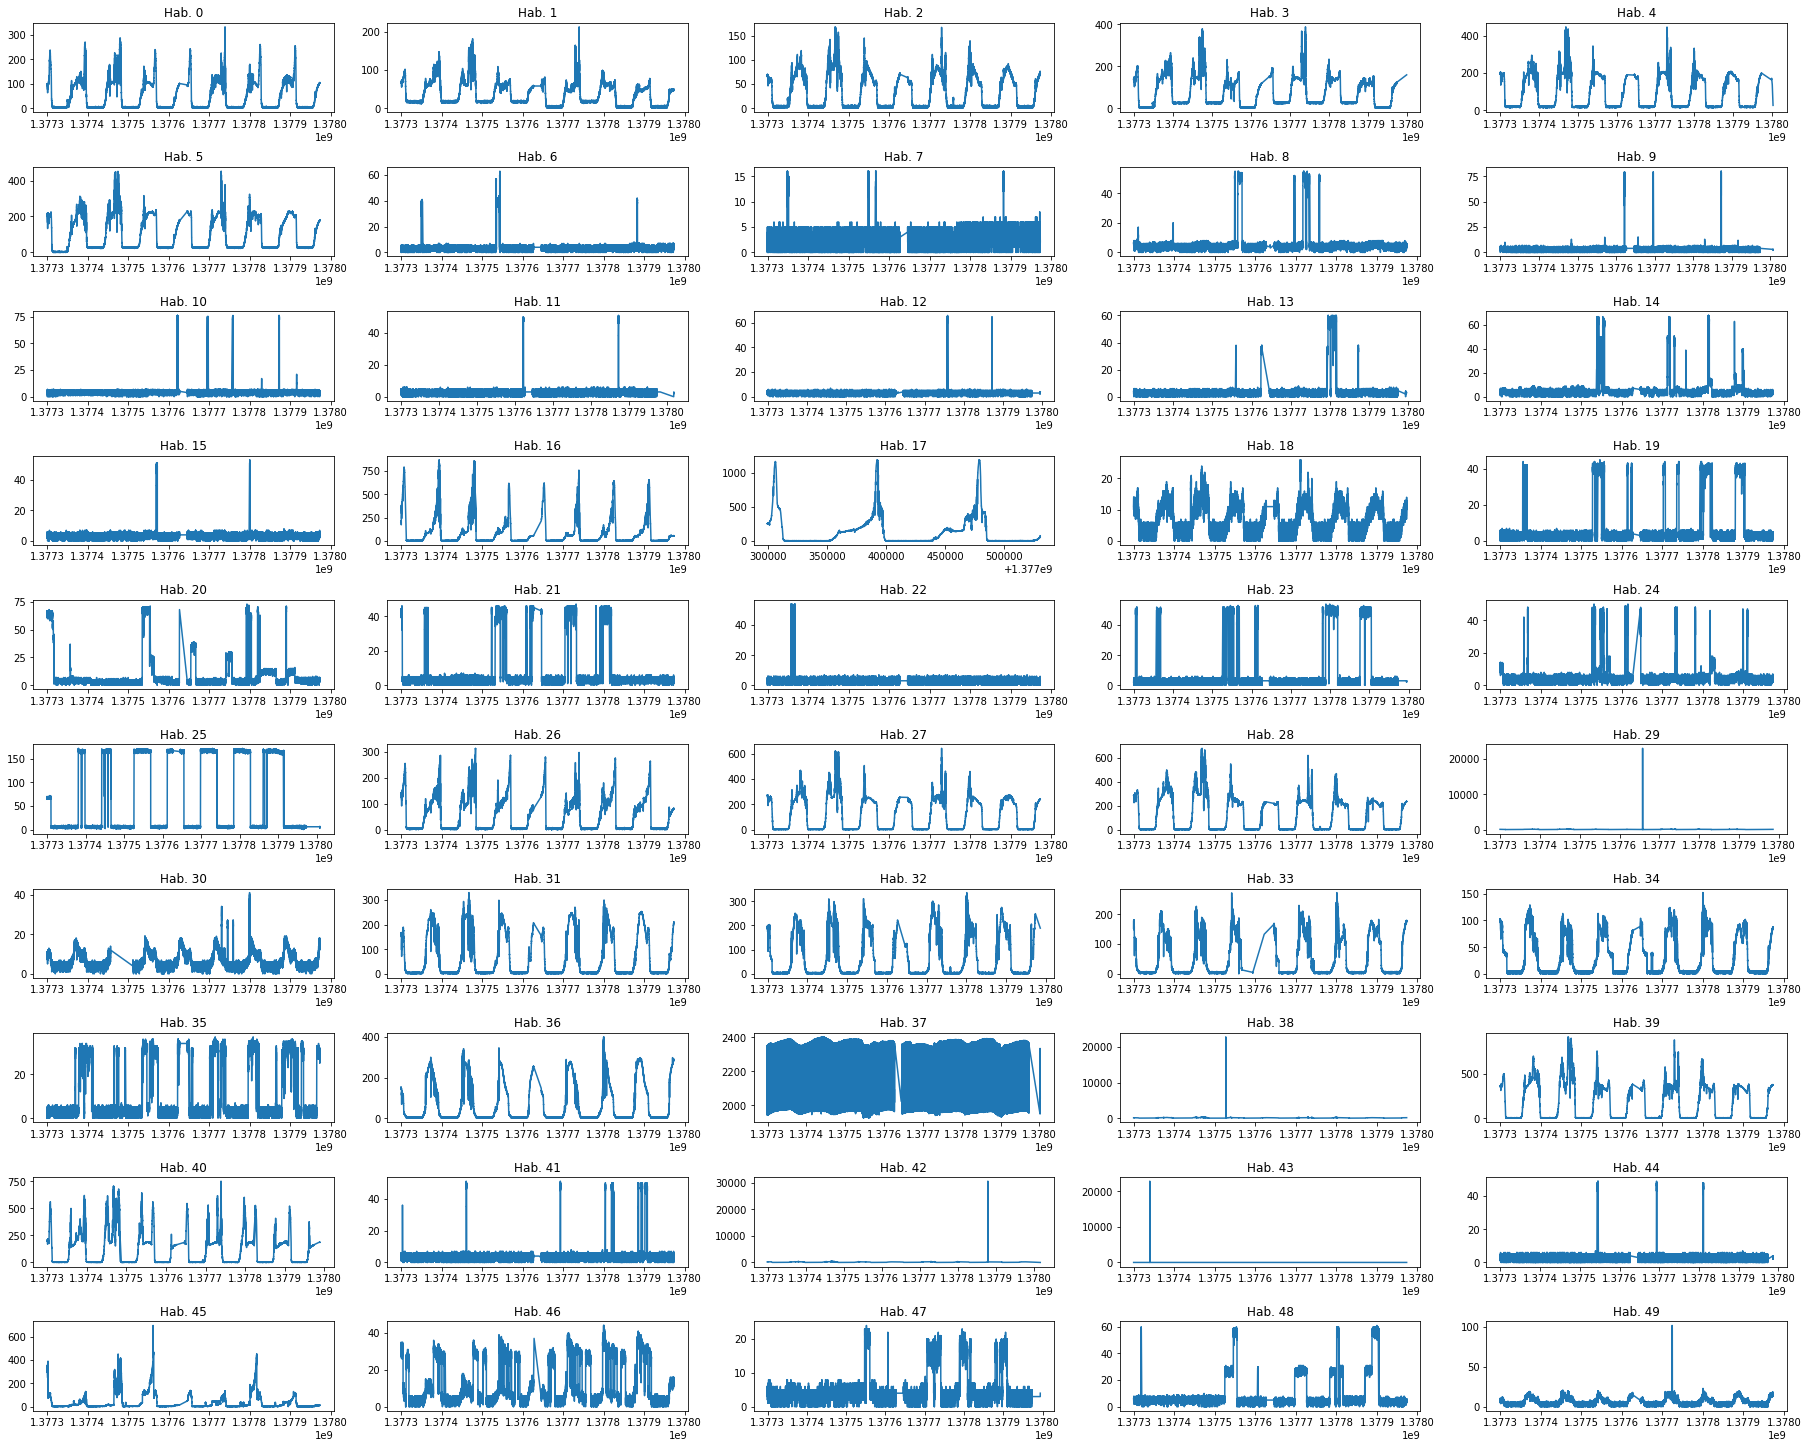

In [ ]:
print_cat('Light')

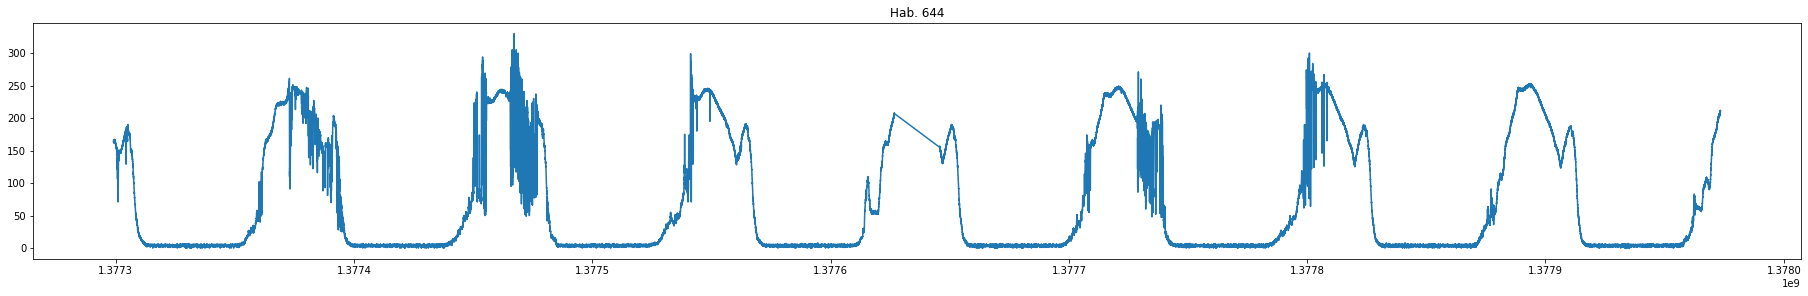

In [ ]:
plot_1_room(31,'Light')

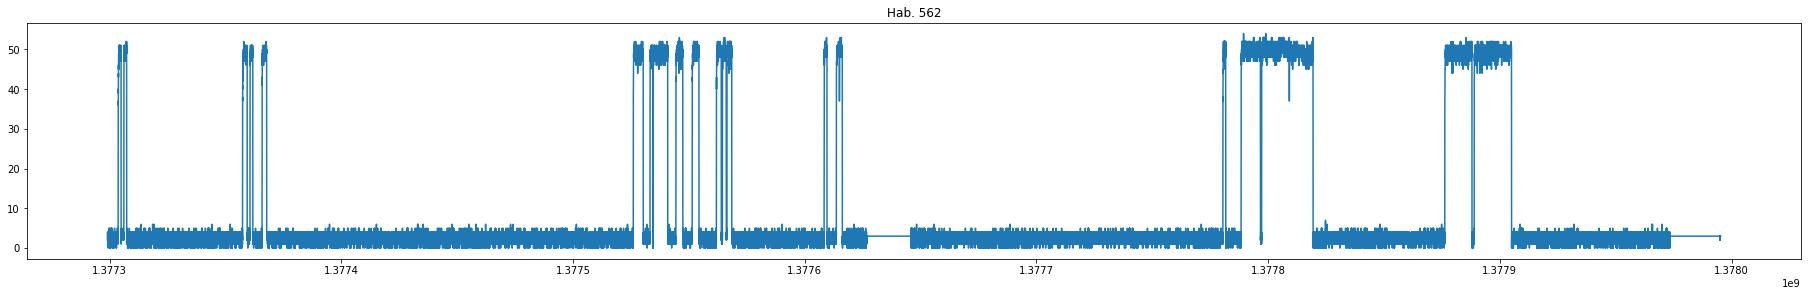

In [ ]:
plot_1_room(23,'Light')

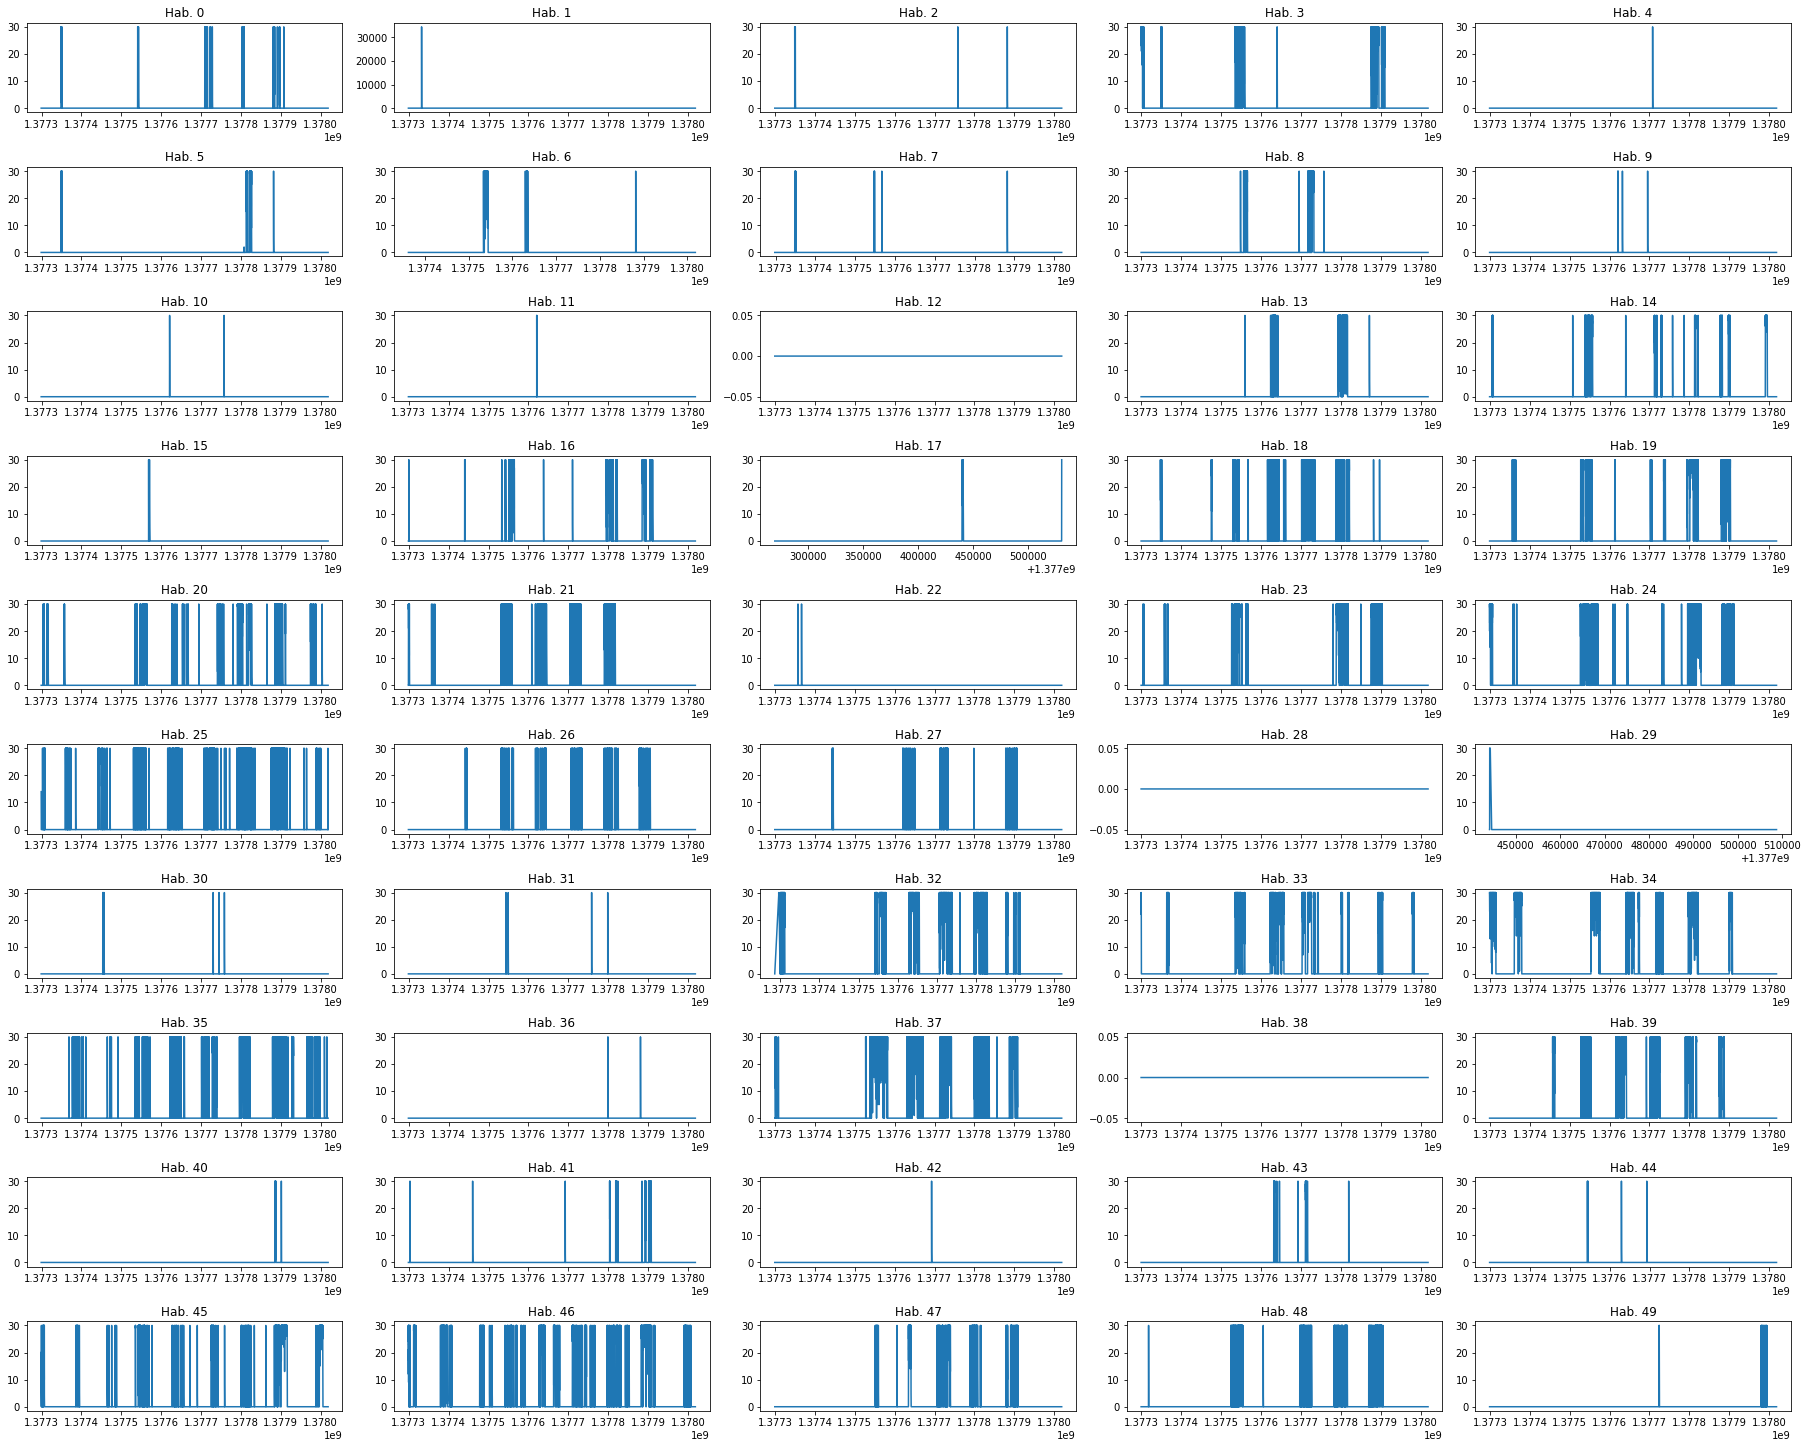

In [ ]:
print_cat('Pir')

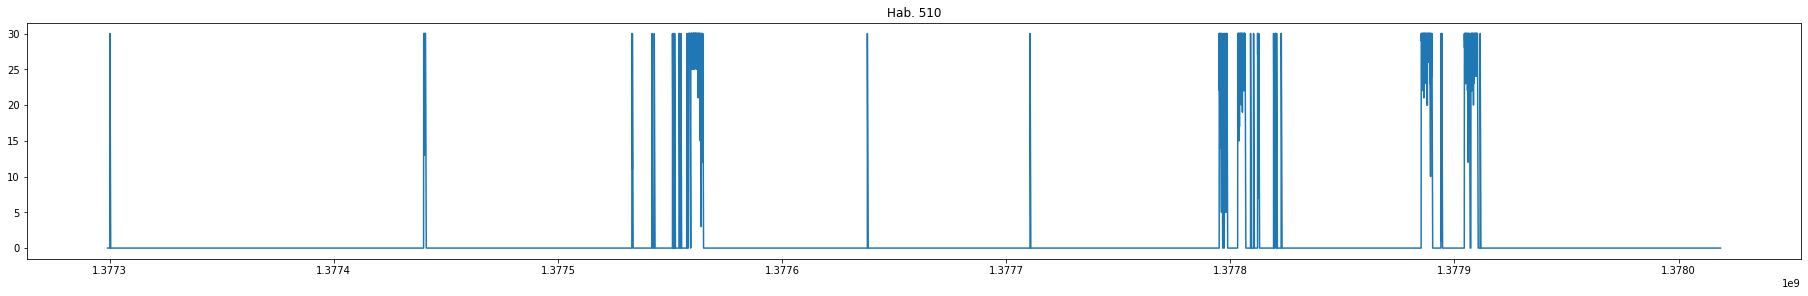

In [ ]:
plot_1_room(16,'Pir')

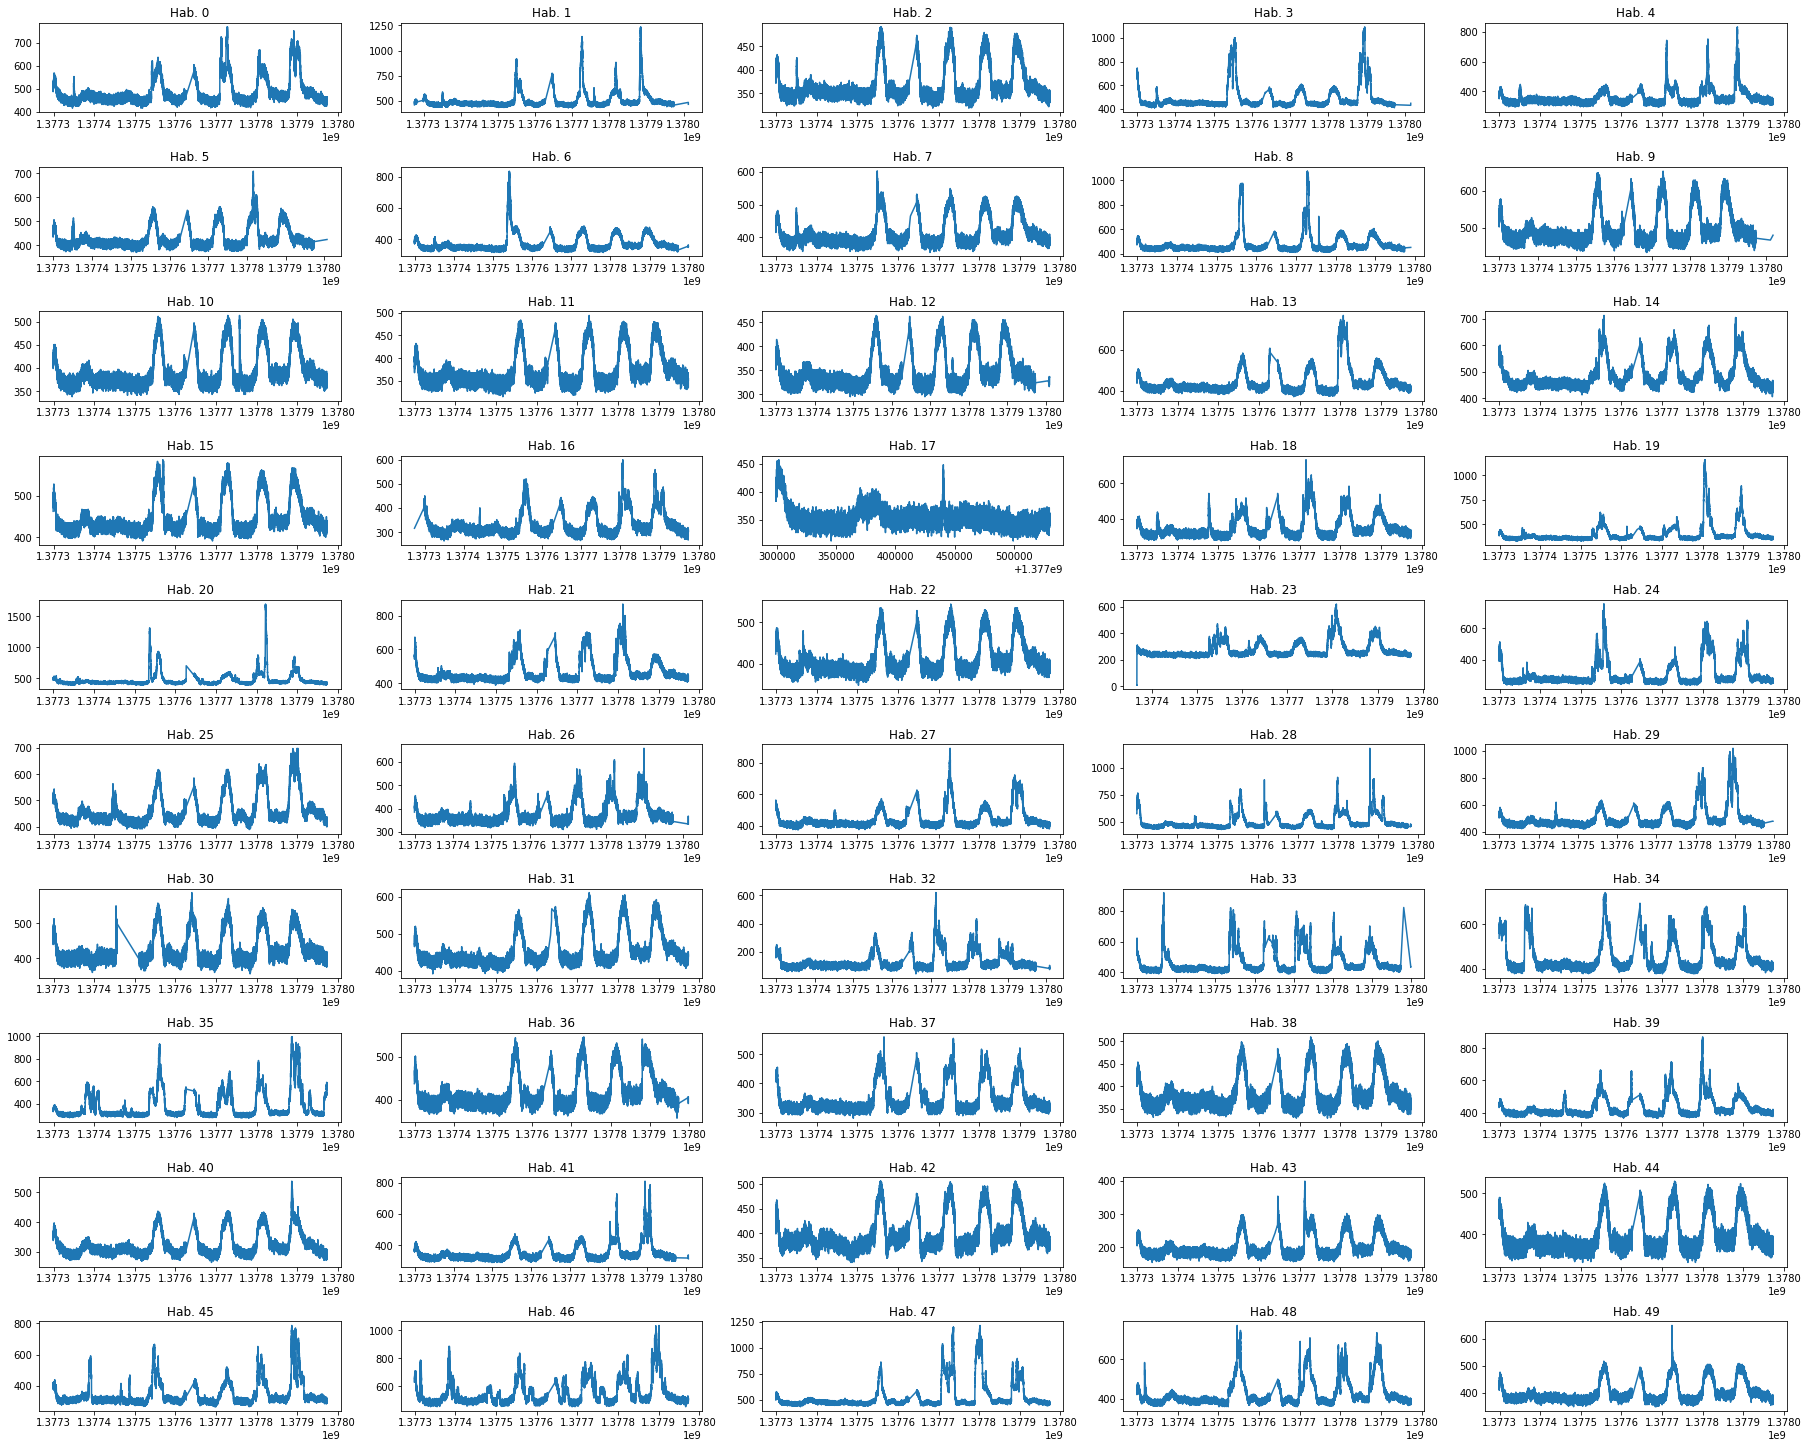

In [ ]:
print_cat('co2')

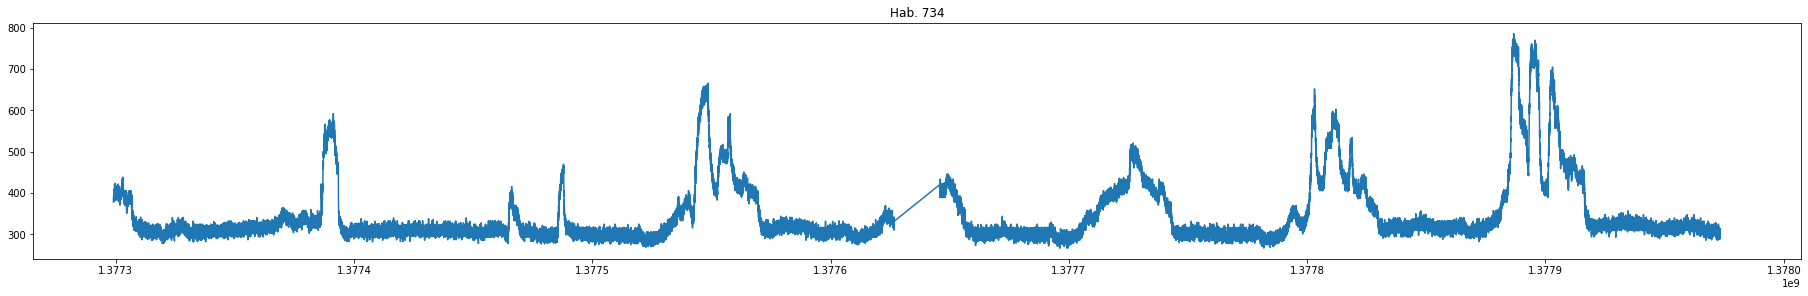

In [ ]:
plot_1_room(45,'co2')

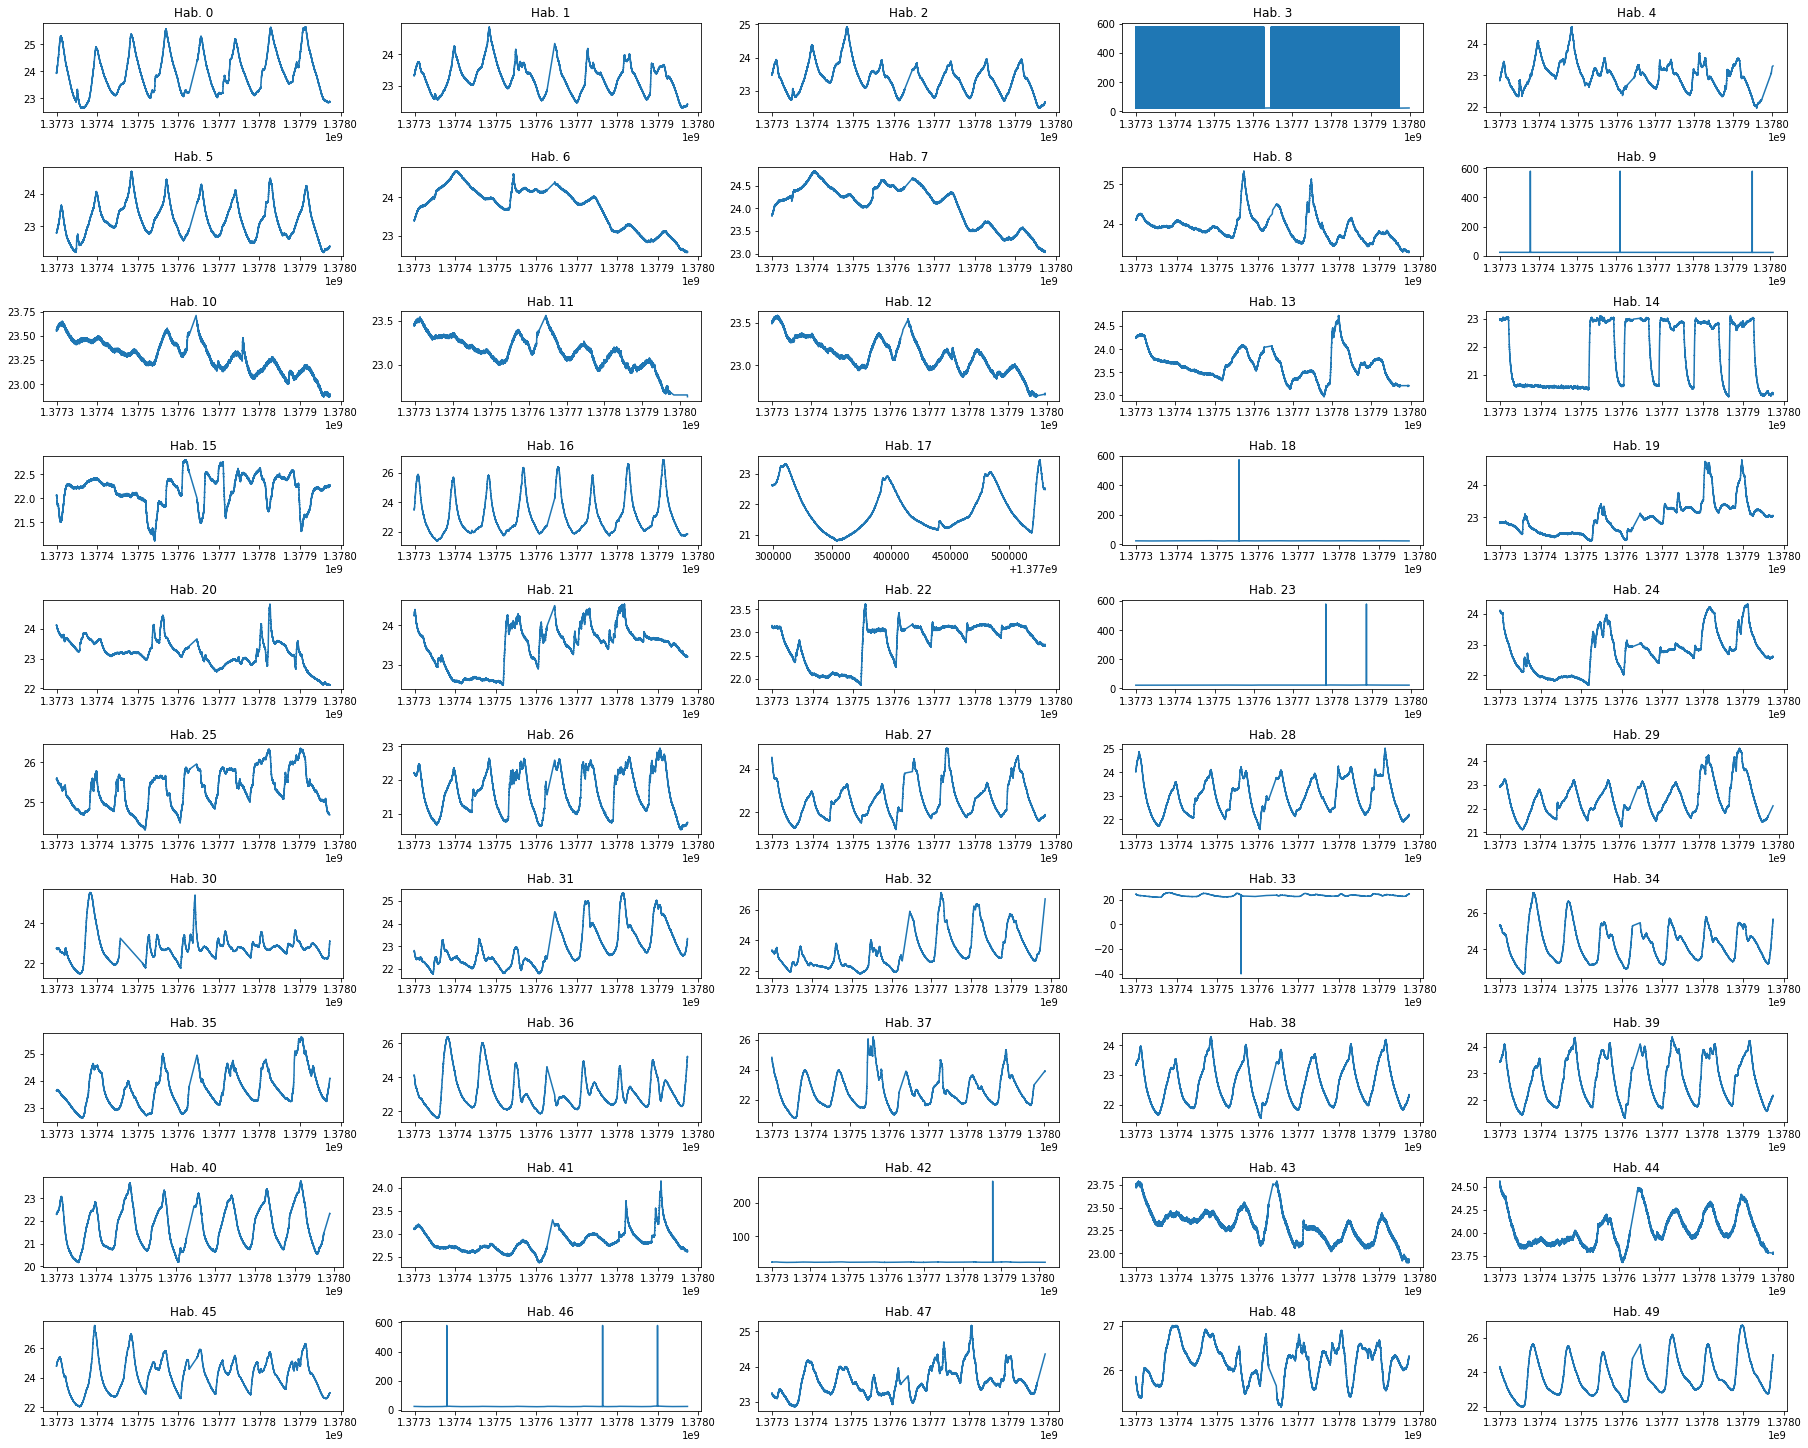

In [ ]:
print_cat('Temperature')

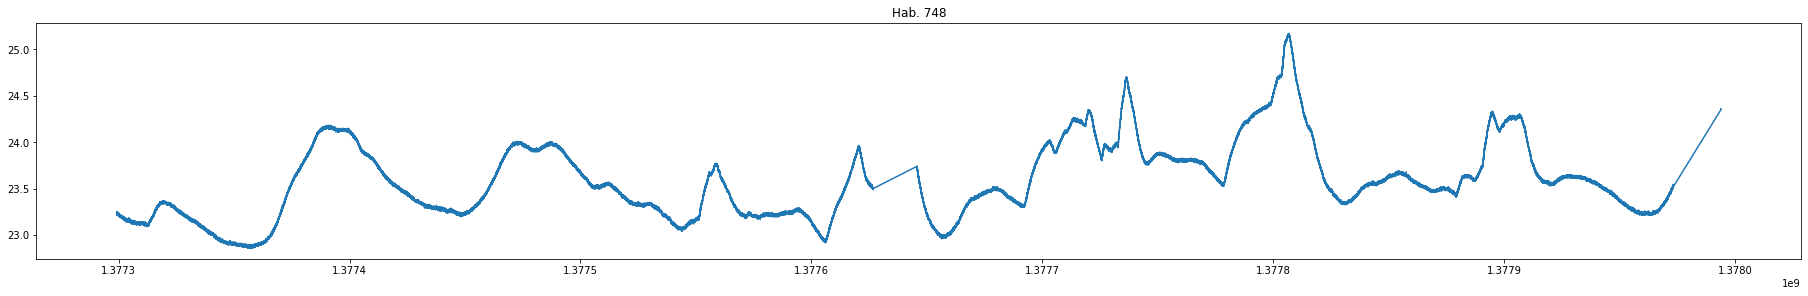

In [ ]:
plot_1_room(47,'Temperature')

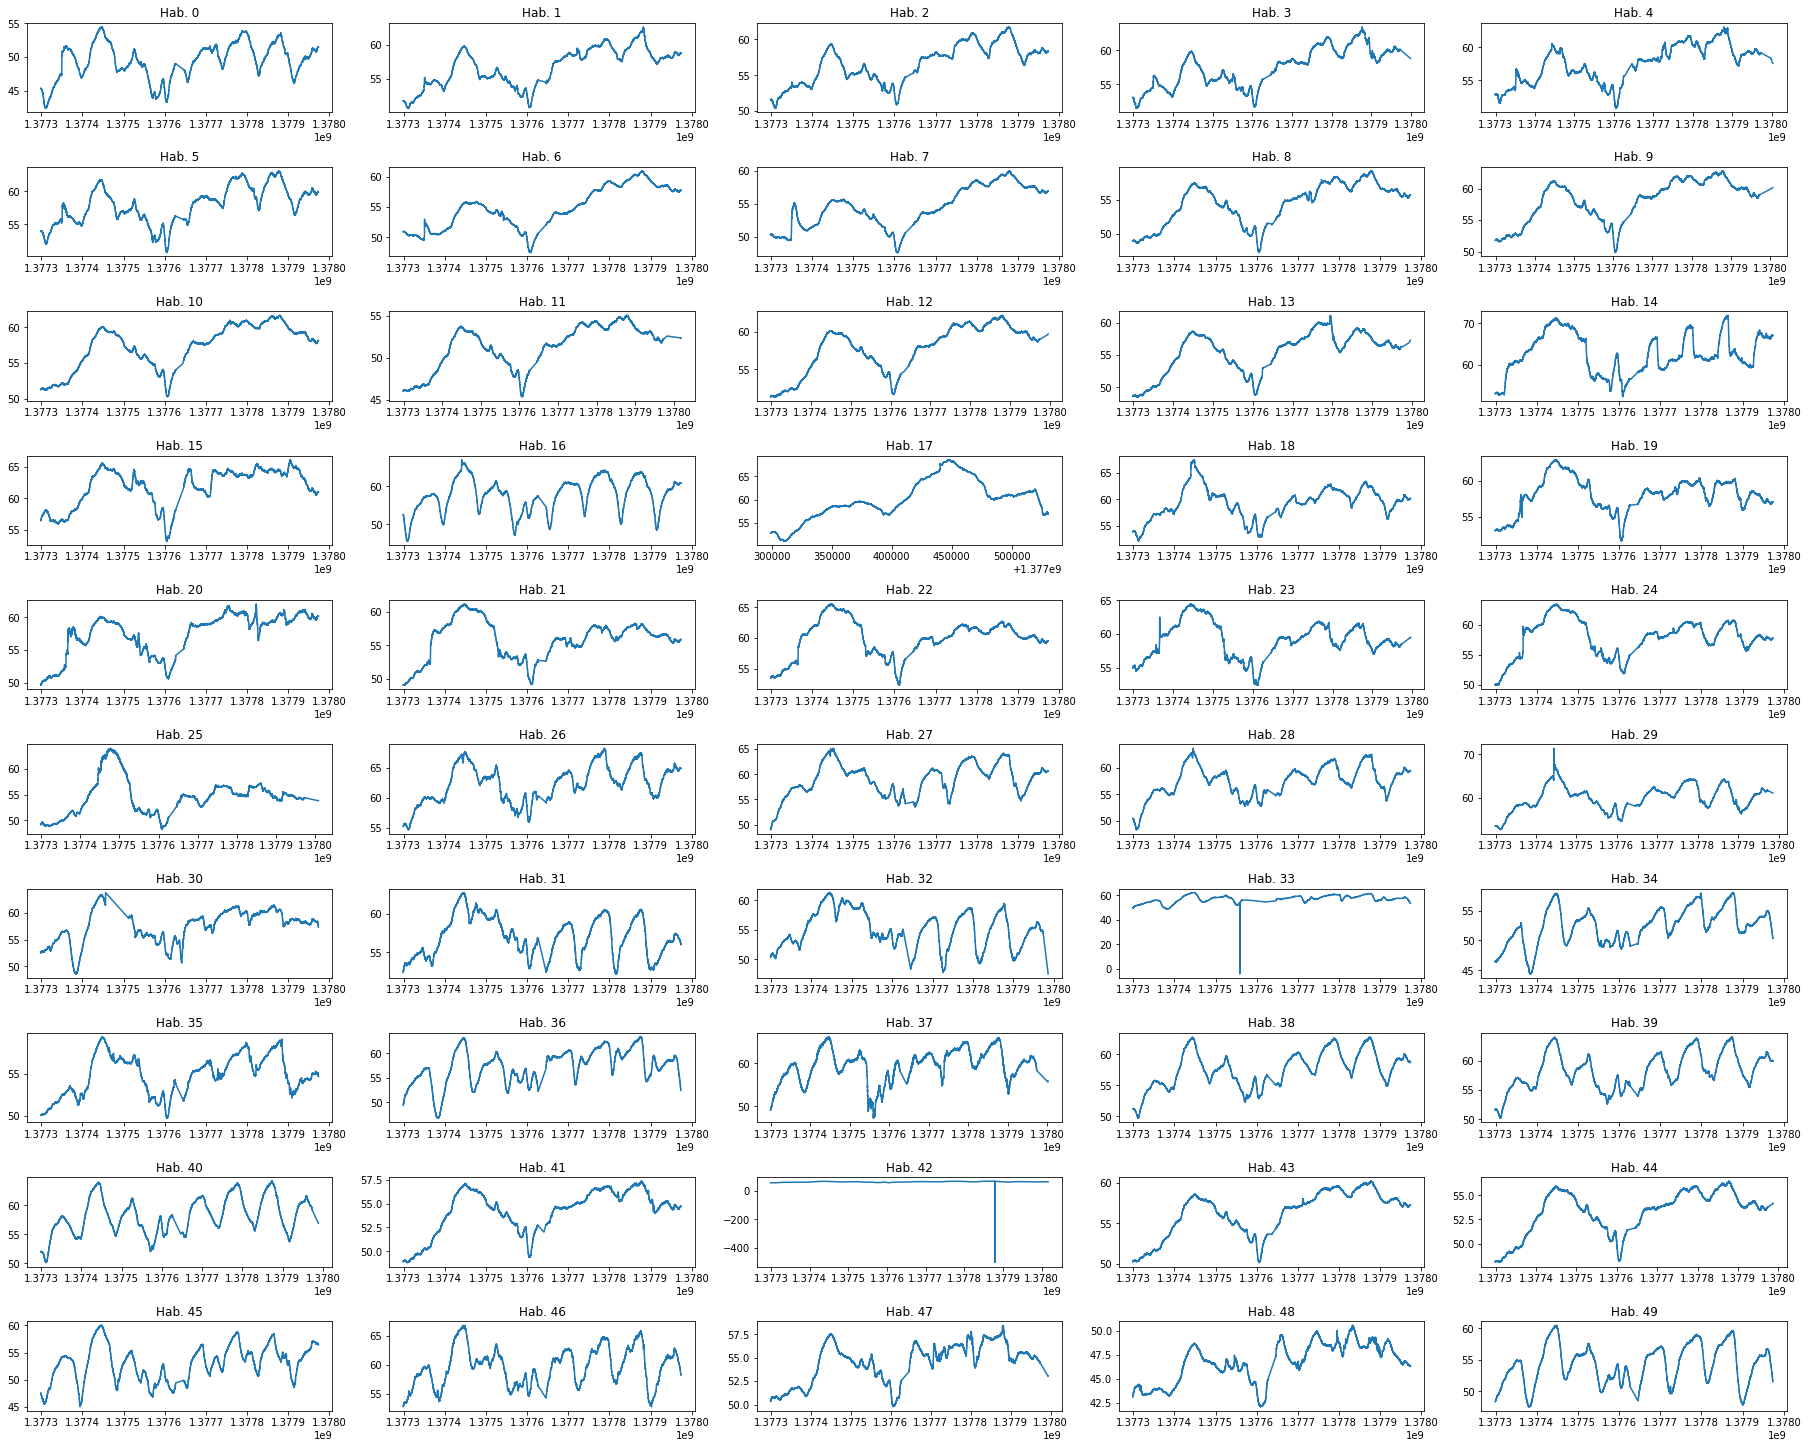

In [ ]:
print_cat('Humidity')

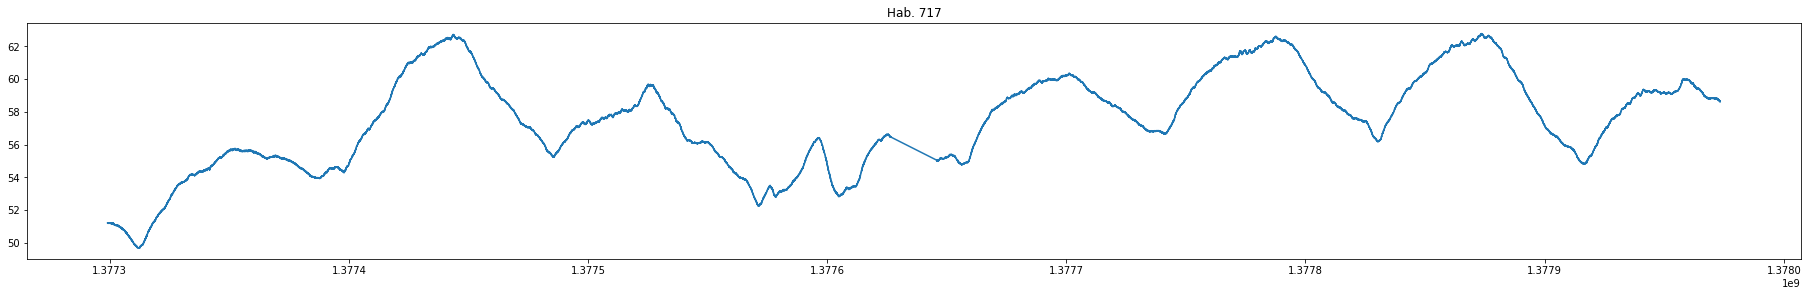

In [ ]:
plot_1_room(38,'Humidity')

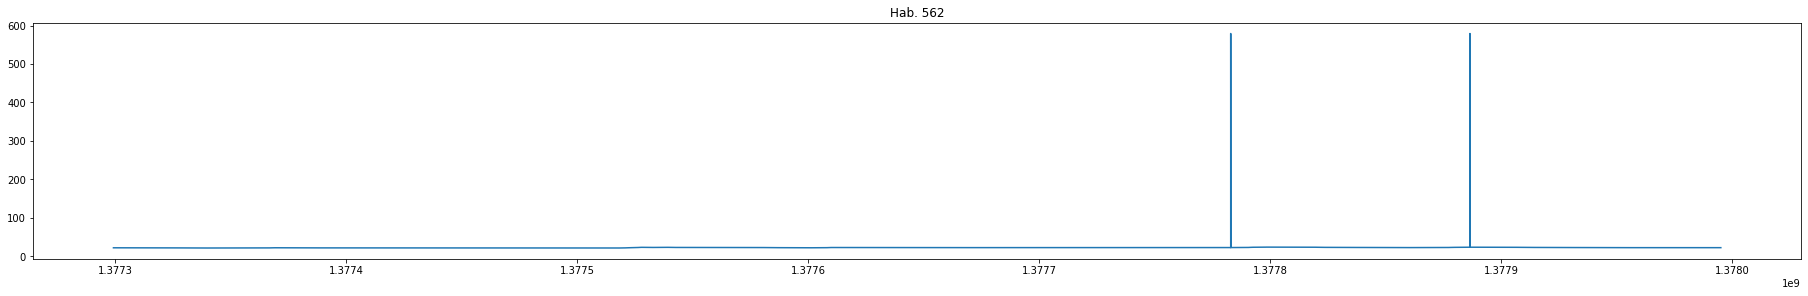

In [ ]:
plot_1_room(23,'Temperature')